In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
#         print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading the images and the labels

#### Dataset A

In [16]:
path = "/kaggle/input/labeled-chest-xray-images/chest_xray/train"

train_images_a, train_labels_a = [], []

for i in os.listdir(path):
    for j in os.walk(os.path.join(path, i)):
        for k in j[2]:
            train_images_a.append(os.path.join(path, i, k))
            train_labels_a.append(i)
        
path = "/kaggle/input/labeled-chest-xray-images/chest_xray/test"

test_images_a, test_labels_a = [], []

for i in os.listdir(path):
    for j in os.walk(os.path.join(path, i)):
        for k in j[2]:
            test_images_a.append(os.path.join(path, i, k))
            test_labels_a.append(i)
            
train_images_a, test_images_a, train_labels_a, test_labels_a = np.array(train_images_a), np.array(test_images_a), np.array(train_labels_a), np.array(test_labels_a)

In [17]:
train_images_a.shape, test_images_a.shape

((5232,), (624,))

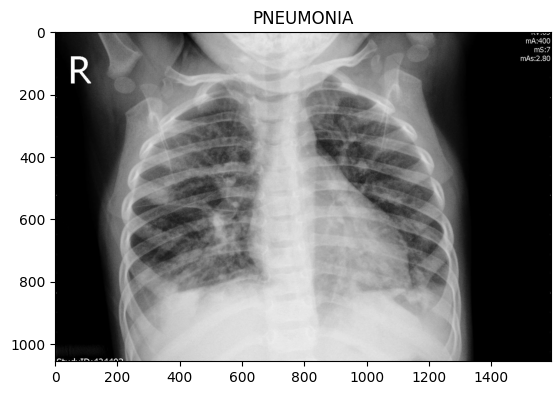

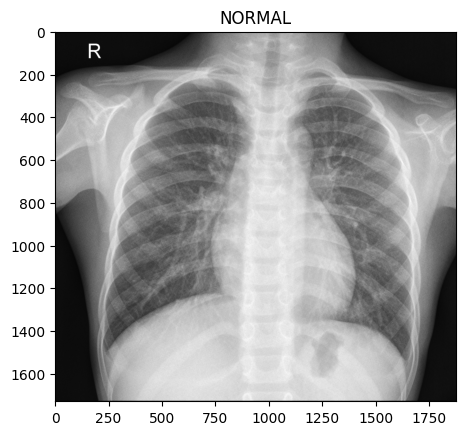

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_image(idx):
    img = Image.open(train_images_a[idx])
    plt.imshow(img, cmap='gray')
    plt.title(train_labels_a[idx])
    plt.show()
    
plot_image(42)
plot_image(5000)

In [ ]:
# Checking for class imbalance
pd.Series(train_labels_a).value_counts(normalize=True)

Clearly, there is some class imbalance in the given dataset. Let us go ahead and remove some of the `PNEUMONIA` images to handle this imbalance.

Note -> We have a total of 3883 images with the label `PNEUMONIA`.

In [ ]:
import random

# Getting random indices
random_idx = random.sample(range(0, 3883), round(3883/1.6))
# Removing the indices
train_labels_a = pd.Series(train_labels_a).drop(random_idx).reset_index(drop=True)
train_images_a = pd.Series(train_images_a).drop(random_idx).reset_index(drop=True)

In [21]:
# Looking at the classes now
pd.Series(train_labels_a).value_counts(normalize=True)

PNEUMONIA    0.519073
NORMAL       0.480927
Name: proportion, dtype: float64

#### Dataset B

In [22]:
from sklearn.model_selection import train_test_split

path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"

images, labels = [], []

for i in os.listdir(path)[:800]:
        images.append(os.path.join(path, i))
        labels.append("Normal")
        
path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"

for i in os.listdir(path):
        images.append(os.path.join(path, i))
        labels.append("Tuberculosis")
        
train_images_b, test_images_b, train_labels_b, test_labels_b = train_test_split(images, labels,
                                                                                stratify=labels,
                                                                                test_size=0.2,
                                                                                random_state=42)

train_images_b, test_images_b, train_labels_b, test_labels_b = np.array(train_images_b), np.array(test_images_b), np.array(train_labels_b), np.array(test_labels_b)

In [23]:
train_images_b.shape, test_images_b.shape

((1200,), (300,))

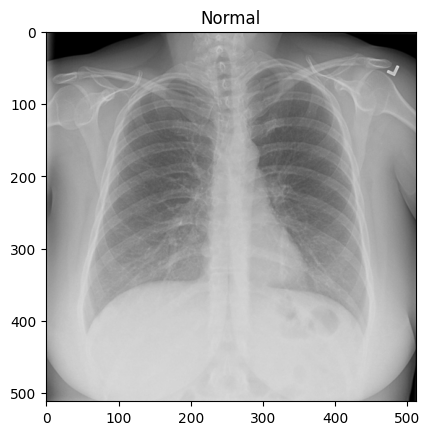

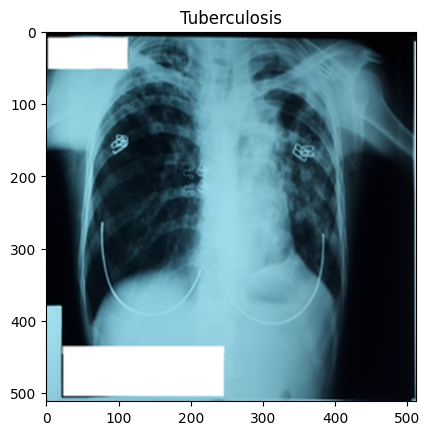

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_image(idx):
    img = Image.open(train_images_b[idx])
    plt.imshow(img, cmap='gray')
    plt.title(train_labels_b[idx])
    plt.show()
    
plot_image(42)
plot_image(1000)

In [25]:
# Checking for class imbalance
pd.Series(train_labels_b).value_counts(normalize=True)

Normal          0.533333
Tuberculosis    0.466667
Name: proportion, dtype: float64

### Creating the Dataset Class

In [26]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, paths, labels, classes, mode="train"):
        super().__init__()
        self.paths = paths
        self.labels = labels
        self.classes = classes
        self.mode = mode
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # Loading the image
        image = Image.open(self.paths[idx]).convert("RGB")
        image = image.resize((256, 256))
        # Data Augmentation
        if self.mode == "train":
            # Data Augmentation
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = preprocess(image)
        else:
            preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        # Loading the label
        label = self.labels[idx]
        label_idx = np.where(np.array(self.classes)==label)[0][0]
        label = torch.zeros(2, dtype=torch.float32)
        label[label_idx] = 1.0
        return image, label

In [27]:
obj = Data(train_images_a, train_labels_a, ["NORMAL", "PNEUMONIA"])
obj.__getitem__(42)

(tensor([[[-2.1179, -2.0837, -1.9980,  ..., -1.0219, -0.6452, -0.2171],
          [-2.1179, -2.1008, -2.0152,  ...,  0.0227, -0.9705, -0.6794],
          [-2.1179, -2.1179, -2.0494,  ..., -0.1657,  0.2111, -0.6965],
          ...,
          [-1.9809, -1.9980, -1.9980,  ..., -1.9467, -1.9638, -1.9295],
          [-1.9809, -1.9980, -1.9980,  ..., -1.9467, -1.9467, -1.9467],
          [-1.9809, -1.9980, -1.9980,  ..., -1.9295, -1.9467, -1.9638]],
 
         [[-2.0357, -2.0007, -1.9132,  ..., -0.9153, -0.5301, -0.0924],
          [-2.0357, -2.0182, -1.9307,  ...,  0.1527, -0.8627, -0.5651],
          [-2.0357, -2.0357, -1.9657,  ..., -0.0399,  0.3452, -0.5826],
          ...,
          [-1.8957, -1.9132, -1.9132,  ..., -1.8606, -1.8782, -1.8431],
          [-1.8957, -1.9132, -1.9132,  ..., -1.8606, -1.8606, -1.8606],
          [-1.8957, -1.9132, -1.9132,  ..., -1.8431, -1.8606, -1.8782]],
 
         [[-1.8044, -1.7696, -1.6824,  ..., -0.6890, -0.3055,  0.1302],
          [-1.8044, -1.7870,

### Training a ResNet

In [28]:
# Loading the pre-trained model
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
from torch import nn

# Freezing the first 8 layers
ct = 0
for i in resnet.children():
    ct+=1
    if ct<9:
        for param in i.parameters():
            param.requires_grad_(False)

# Replacing the final layer
resnet.fc = nn.Linear(in_features=2048, out_features=2)

resnet.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### ResNet for Dataset A

In [30]:
from tqdm.auto import tqdm

# Creating datasets
train_data = Data(train_images_a, train_labels_a, ["NORMAL", "PNEUMONIA"])
val_data = Data(test_images_a, test_labels_a, ["NORMAL", "PNEUMONIA"], mode="test")

# Creating dataloader classes
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, pin_memory=True)

# Enabling GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = nn.DataParallel(resnet)
resnet = resnet.to(device)

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    total_steps=len(train_dataloader)*20,
    final_div_factor=1.0,
)

# Keeping track of loss
loss_l = []


for epoch in range(20):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for img, label in pbar:
        img = img.to(device)
        label = label.to(device)
        
        outputs = resnet(img)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        del img
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

  0%|          | 0/88 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(resnet, val_dataloader, criterion)

### ResNet for Dataset B

In [ ]:
from tqdm.auto import tqdm

# Creating datasets
train_data = Data(train_images_b, train_labels_b, ["Normal", "Tuberculosis"])
val_data = Data(test_images_b, test_labels_b, ["Normal", "Tuberculosis"], mode="test")

# Creating dataloader classes
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, pin_memory=True)

# Enabling GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    total_steps=len(train_dataloader)*20,
    final_div_factor=1.0,
)

# Keeping track of loss
loss_l = []


for epoch in range(20):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for img, label in pbar:
        img = img.to(device)
        label = label.to(device)
        
        outputs = resnet(img)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        del img
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(resnet, val_dataloader, criterion)

### Building a custom CNN

In [ ]:
from tqdm.auto import tqdm

class CustomCNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding="same")

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)

        self.dense1 = nn.LazyLinear(512)
        self.dense2 = nn.Linear(512, 512)

        self.silu = nn.SiLU()
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, 2)

        # Batch normalization layers after convolutions
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, input_t):
        x = self.silu(self.bn1(self.pool(self.conv1(input_t))))
        x = self.silu(self.bn2(self.pool(self.conv2(x))))
        x = self.silu(self.bn3(self.pool(self.conv3(x))))
        x = self.silu(self.bn4(self.pool(self.conv4(x))))
        x = self.flatten(x)
        x = self.silu(self.dense1(x))
        x = self.dropout(x)
        x = self.silu(self.dense2(x))
        x = self.dropout(x)
        x = self.softmax(self.classifier(x))
        return x

### Custom CNN for Dataset A

In [ ]:
# Creating the model
model = CustomCNN(2)

# Running a dummy forward pass
dummy_input = torch.randn(1, 3, 256, 256)
model(dummy_input)

model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Creating datasets
train_data = Data(train_images_a, train_labels_a, ["NORMAL", "PNEUMONIA"])
val_data = Data(test_images_a, test_labels_a, ["NORMAL", "PNEUMONIA"], mode="test")

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(val_data, batch_size=16, shuffle=True, pin_memory=True)

# Creating a learning rate scheduler
total_batches = len(train_loader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01, 
    total_steps=total_batches * 20, 
    final_div_factor=10.0
)

# Keeping track of the loss
loss_l = []

# Training loop
for epoch in range(20):
    pbar = tqdm(train_loader, total=len(train_loader))
    for image, label in pbar:
        # Moving the data to GPU
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler
        lr_scheduler.step()
        
        del image
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(model, test_loader, criterion)

### Custom CNN for Dataset B

In [ ]:
# Creating the model
model = CustomCNN(2)

# Running a dummy forward pass
dummy_input = torch.randn(1, 3, 256, 256)
model(dummy_input)

model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initializing the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Creating datasets
train_data = Data(train_images_b, train_labels_a, ["NORMAL", "PNEUMONIA"])
val_data = Data(test_images_b, test_labels_a, ["NORMAL", "PNEUMONIA"], mode="test")

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(val_data, batch_size=16, shuffle=True, pin_memory=True)

# Creating a learning rate scheduler
total_batches = len(train_loader)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.01, 
    total_steps=total_batches * 20, 
    final_div_factor=10.0
)

# Keeping track of the loss
loss_l = []

# Training loop
for epoch in range(20):
    pbar = tqdm(train_loader, total=len(train_loader))
    for image, label in pbar:
        # Moving the data to GPU
        image = image.to(device)
        label = label.to(device)
        
        # Forward pass
        outputs = model(image)
        loss = criterion(outputs, label)
        loss_l.append(loss.detach().to("cpu"))
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Learning rate scheduler
        lr_scheduler.step()
        
        del image
        del label
        
        pbar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(loss_l)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model evaluation
def evaluate(model, test_dataloader, criterion):
    # Keeping track of model performance on the test set
    y_true, y_pred = [], []
    # Putting the model in evaluation mode
    model.eval()
    with torch.no_grad():
        pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Evaluating")
        for text, labels in pbar:
            text = text.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(text)
            # Obtaining the most likely predicted class
            y_pred.extend(torch.argmax(outputs, dim=1).to("cpu"))
            y_true.extend(torch.argmax(labels, dim=1).to("cpu"))
    # Calculating metrics
    print(classification_report(y_true, y_pred))
    
evaluate(model, test_loader, criterion)

# End